In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import kerastuner as kt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import robust_laplacian
from scipy.sparse.linalg import eigsh
import gpytoolbox as gpy
from scipy.spatial import ConvexHull
from scipy.interpolate import RBFInterpolator
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go

2025-07-14 17:28:11.402370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752523091.418908  518818 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752523091.424320  518818 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752523091.437269  518818 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752523091.437285  518818 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752523091.437287  518818 computation_placer.cc:177] computation placer alr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
tf.random.set_seed(314159)
np.random.seed(314159)

In [3]:
umin = 0.0
umax = 2*np.pi
vmin = -np.pi/2
vmax = np.pi/2

In [4]:
# Compute the area density element dA of the surface - p is a point (u,v) intrinsic to the surface
def areaDensity(p, surface):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(p)
    u = p[:,0]
    v = p[:,1]
    s = surface(u, v)

  J = tape.batch_jacobian(s, p)

  s_u = J[:,:,0]
  s_v = J[:,:,1]

  cross_product = tf.linalg.cross(s_u, s_v)

  area = tf.norm(cross_product, keepdims=True, axis=1)

  return area

In [5]:
# Helper function - finds the max area element on the surface for rejection sampling later.
def findBound(surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, size_grid=100):
  u = tf.linspace(umin, umax, size_grid)
  v = tf.linspace(vmin, vmax, size_grid)

  u, v = tf.meshgrid(u, v)
  pts = tf.stack([tf.reshape(u, [-1]), tf.reshape(v, [-1])], axis=1)

  areas = areaDensity(pts, surface)

  return tf.reduce_max(areas)

In [6]:
# Specifying the cosine bell for advection:
# bell_min, bell_max specify radius of the bell
# minest_height, maxest_height specify amplitude of bell

bell_min = 0.5
bell_max = 0.5
minest_height = 950.0
maxest_height = 1000.0

tmin = 0.0
tmax = 1.0

# How much the bell advects over the sphere (angle controlled by the numerator). Generally less stable for larger angles, try < pi/2 for more curved surfaces and pi for less curved.
omega = 0.5 * np.pi / tmax

In [7]:
# def sphere(u, v, a=1.0, b=1.0, c=1.0):
#   return tf.stack([a * tf.sin(u) * tf.cos(v), b * tf.sin(u) * tf.sin(v), c * tf.cos(u)], axis=1)

In [8]:
f = lambda u, v: 1 + 0.2 * tf.sin(5.0 * u) * tf.sin(5.0 * v)

In [9]:
def sphere(u, v):
    return tf.stack([f(u,v) * tf.sin(u) * tf.cos(v), f(u,v) * tf.sin(u) * tf.sin(v), f(u,v) * tf.cos(u)], axis=1)

In [10]:
# Define the starting position of the cosine bell on the surface
center = tf.squeeze(sphere(tf.constant([0.0], dtype=tf.float32), tf.constant([0.0], dtype=tf.float32))); center

I0000 00:00:1752523094.928190  518818 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5135 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:02:00.0, compute capability: 8.6


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>

In [11]:
# Approximates the normal vector at each point
def normalVector(xyz, knn=30):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    # Use a knn search to estimate normals
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn)
    )
    # Orient the normals all in the same direction
    pcd.orient_normals_towards_camera_location(pcd.get_center())
    normals = np.asarray(pcd.normals, dtype=np.float32)
    return normals / np.linalg.norm(normals, axis=1, keepdims=True)

In [12]:
# Get the projection matrix onto the surface at each point.
def projMatrix(x, y, z, normals):
    p = tf.stack([x, y, z], axis=1)
    n = normals
    n = tf.expand_dims(n, axis=2)
    n_outer = tf.matmul(n, tf.transpose(n, [0, 2, 1]))
    I = tf.eye(3, batch_shape=[tf.shape(p)[0]])
    return I - n_outer

In [13]:
# Generate a new set of initial conditions (cosine bells)
def bellAndHeight(n, bmin=bell_min, bmax=bell_max, hmin=minest_height, hmax=maxest_height):
    bell_radii = tf.random.uniform((n, 1), minval=bmin, maxval=bmax)
    max_heights = tf.random.uniform((n, 1), minval=hmin, maxval=hmax)

    return bell_radii, max_heights

In [14]:
# Defines the cosine bell at each point (x, y, z) on the surface.
# Each bell is specified by two (n, 1) tensors dictating the radius and amplitude of the bell for that IC (bell_radii and max_heights, respectively)
def u0(x, y, z, bell_radii, max_heights, center=center):
    x0 = center[0]
    y0 = center[1]
    z0 = center[2]
    
    # Euclidean distance in R3 for determining if a point lies in the bell
    r = tf.sqrt((x - x0)**2 + (y - y0)**2 + (z - z0)**2)

    # Cosine bell profile
    h = (max_heights / 2) * (1 + tf.cos(np.pi * r / bell_radii)) / maxest_height

    return tf.where(r < bell_radii, h, tf.zeros_like(h))

In [15]:
# Axis of rotation
k = tf.constant([[1.0, 0.0, 0.0]], dtype=tf.float32)

In [16]:
# Defines the velocity field along which the bell advects.
# normal is the corresponding normal tensor for each point in xyz
# k is the axis of rotation, omega is by what angle the bell advects
def vel_field(x, y, z, normal, k=k, omega=omega):
    xyz = tf.stack([x, y, z], axis=-1)

    # Defines the standard rotation vector field for the axis k and velocity omega
    omega_vec = tf.tile(k * omega, [xyz.shape[0], 1])
    rot_vf = tf.linalg.cross(omega_vec, xyz)

    # To get the vector field on the surface, just use our projection matrix from earlier
    return tf.squeeze(projMatrix(x, y, z, normal) @ tf.expand_dims(rot_vf, axis=-1))

In [17]:
# Generates (u,v) points for some surface that are evenly sampled (via rejection sampling)
# saftey_factor dictates by how much to oversample so we reach the desired number of points - generally make it higher for less smooth surfaces
def generateDomainPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, saftey_factor=5):
  batch_size = n * saftey_factor

  # The max area element on the surface
  max = findBound(surface, size_grid=100, umin=umin, umax=umax, vmin=vmin, vmax=vmax)

  U = tf.random.uniform((batch_size,), minval=umin, maxval=umax)
  V = tf.random.uniform((batch_size,), minval=vmin, maxval=vmax)
  W = tf.random.uniform((batch_size,), minval=0.0, maxval=1.0)

  P = tf.stack([U, V], axis=1)
  A = areaDensity(P, surface) / (max * 1.05)

  mask = W <= tf.squeeze(A)

  accept_U = tf.boolean_mask(U, mask)
  accept_V = tf.boolean_mask(V, mask)

  if tf.shape(accept_U)[0] < n or tf.shape(accept_V)[0] < n:
    print('Not enough points generated - increase saftey_factor')
    return
  
  accept_U = accept_U[0:n]
  accept_V = accept_V[0:n]
  domain_pts = tf.stack([accept_U, accept_V], axis=1)

  if tf.shape(domain_pts)[0] > n:
    domain_pts = domain_pts[:,0:n]

  return domain_pts

In [18]:
# Generates evenly spaced (x, y, z, t) points on a surface
def generateCollocationPoints(n, surface, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0, tmax=1.0):
  domain_pts = generateDomainPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax)
  xyz = surface(domain_pts[:,0], domain_pts[:,1])
  t = tf.random.uniform((n,), minval=tmin, maxval=tmax)
  return tf.stack([xyz[:,0], xyz[:,1], xyz[:,2], t], axis=1)

In [19]:
def generateInitialPoints(n, surface, bell_radii, max_heights, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0):
  xyz = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax)[:,0:3]
  x = xyz[:,0:1]
  y = xyz[:,1:2]
  z = xyz[:,2:3]
  t = tf.ones_like(x) * tmin
  return tf.squeeze(tf.stack([x, y, z, t, u0(x, y, z, bell_radii, max_heights)], axis=1))

In [20]:
# Main parameters for model. N_inputs can be thought of as the batch size (we sample 1 collocation point per initial condition, and somehow this works). 
N_sensor = 256
N_inputs = 10000
width = 50
depth = 6

In [21]:
# The sensor points. We give it the shape (1, N_sensor, 3) so that we can get a tensor of shape (N_inputs, N_sensor) from our initial condition
sensor_points = tf.expand_dims(generateCollocationPoints(N_sensor, sphere, umin=umin, umax=umax, vmin=vmin, vmax=vmax)[:,0:3], axis=0)

In [22]:
# Generates all data for training/testing.
# Returns the collocation points (pde_pts), initial condition evaluated at sensor point (u_sensor_points), and the two tensors describing each initial condition (bell_radii, max_heights)
# Note the lack of initial and boundary points - regarding the former we use a hard constraint, and for the latter this code is meant for closed surfaces. However for open surfaces one could just add bc_pts the same way pde_pts is generated and return that
def generatePoints(n, surface, sensor_points, umin=0.0, umax=2*np.pi, vmin=-np.pi/2, vmax=np.pi/2, tmin=0.0, tmax=1.0):
  pde_pts = generateCollocationPoints(n, surface, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin, tmax=tmax)

  sensor_points = tf.tile(sensor_points, [n, 1, 1])

  x_sensor = sensor_points[:,:,0]
  y_sensor = sensor_points[:,:,1]
  z_sensor = sensor_points[:,:,2]

  bell_radii, max_heights = bellAndHeight(n)

  u_sensor_pts = u0(x_sensor, y_sensor, z_sensor, bell_radii, max_heights)

  return pde_pts, u_sensor_pts, bell_radii, max_heights

In [23]:
pde_pts, u_sensor_pts, bell_radii, max_heights = generatePoints(N_inputs, sphere, sensor_points, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin, tmax=tmax)

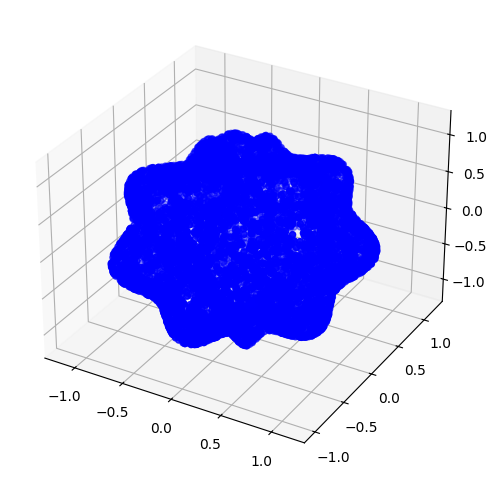

In [24]:
# Plot of the points. While the sampling method should evenly sample the points, it's always best to just make sure they are visually
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
x, y, z = pde_pts[:,0], pde_pts[:,1], pde_pts[:,2]
scatter = ax.scatter(x, y, z, color='blue')
plt.show()

In [25]:
print(pde_pts.shape)
print(u_sensor_pts.shape)
print(bell_radii.shape, max_heights.shape)

(10000, 4)
(10000, 256)
(10000, 1) (10000, 1)


In [26]:
# Approximates the jacobian of the normal field of the surface. This is needed later on for computing surface operators.
# If you have a tensorflow definition for the normals (for instance if the surface is parametrized, not the open3d approximation above), use AD on that instead of this. This however gives more generality.
def compute_normal_jacobian(xyz, normals, k=200, h=0.5):
    N = xyz.shape[0]
    jac = np.zeros((N, 3, 3), dtype=np.float32)

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(xyz)
    distances, indices = nbrs.kneighbors(xyz)

    for i in range(N):
        neigh = indices[i, 1:]
        A = xyz[neigh] - xyz[i]
        B = normals[neigh] - normals[i]

        w = np.exp(- (distances[i,1:]**2) / (h*h))

        Wsqrt = np.sqrt(w)[:, None]
        Aw = A * Wsqrt
        Bw = B * Wsqrt

        J, *_ = np.linalg.lstsq(Aw, Bw, rcond=None)
        jac[i] = J

    return jac

In [27]:
normals = normalVector(pde_pts[:,0:3])
normal_jacobian = tf.convert_to_tensor(compute_normal_jacobian(pde_pts[:,0:3].numpy(), normals), dtype=tf.float32)

In [28]:
# Computes the bounds of pde_pts and u_sensor_pts for normalization. 
# IMPORTANT !!!!!!!!!!!!!!!!!!!!!!! 
# If you get NaNs later on, either from model prediction or in the loss, this is because either pmin=pmax or smin=smax. In this event, comment out the normalization in buildModel causing the issue

# all_pts = tf.concat([pde_pts, ic_pts[:,0:4]], axis=0) # use this one for soft constraints
all_pts = pde_pts # use this one for hard contraint
pmin = tf.reduce_min(all_pts, axis=0)
pmax = tf.reduce_max(all_pts, axis=0)

smin = tf.reduce_min(u_sensor_pts, axis=0) 
smax = tf.reduce_max(u_sensor_pts, axis=0)

In [29]:
class Normalize(tf.keras.layers.Layer):
  def __init__(self, xmin, xmax, name=None, **kwargs):
    super(Normalize, self).__init__(name=name)
    self.xmin = xmin
    self.xmax = xmax
    super(Normalize, self).__init__(**kwargs)

  def call(self, inputs):
    return 2.0*(inputs-self.xmin)/(self.xmax-self.xmin)-1.0

  def get_config(self):
    config = super(Normalize, self).get_config()
    config.update({'xmin': self.xmin, 'xmax': self.xmax})
    return config

In [30]:
# Defines the DeepONet. Takes in an input [x, y, z, t, u_sensor_pts] and returns a tensor shape (N, 1)
def buildModel(width, depth):
  trunk_x = tf.keras.layers.Input(shape=(1,))
  trunk_y = tf.keras.layers.Input(shape=(1,))
  trunk_z = tf.keras.layers.Input(shape=(1,))
  trunk_t = tf.keras.layers.Input(shape=(1,))

  t = tf.keras.layers.Concatenate()([trunk_x, trunk_y, trunk_z, trunk_t])
  t = Normalize(pmin, pmax)(t)
  for i in range(depth):
    t = tf.keras.layers.Dense(width, activation='tanh')(t)
  trunk_out = tf.keras.layers.Dense(width, activation='linear')(t)

  branch_input = b = tf.keras.layers.Input(shape=(N_sensor,))
  # b = Normalize(smin, smax)(b)
  for i in range(depth):
    b = tf.keras.layers.Dense(width, activation='tanh')(b)
  branch_out = tf.keras.layers.Dense(width, activation='linear')(b)

  out = tf.keras.layers.Multiply()([trunk_out, branch_out])
  out = tf.keras.layers.Dense(1, use_bias=True)(out)

  return tf.keras.Model([trunk_x, trunk_y, trunk_z, trunk_t, branch_input], out)

In [31]:
def L2Error(u_true, u_pred):
  return tf.norm(u_true - u_pred) / tf.norm(u_true)

In [32]:
# The hard constraint for this model. It's the standard u = u0 + t/tmax * NN_out
def hardConstraint(model, x, y, z, t, u_sensor_pts, bell_radii, max_heights):
    x, y, z, t = tf.reshape(x, [-1, 1]), tf.reshape(y, [-1, 1]), tf.reshape(z, [-1, 1]), tf.reshape(t, [-1, 1])
    nn = model([x, y, z, t, u_sensor_pts])

    u = u0(x, y, z, bell_radii, max_heights) + (t - tmin) / (tmax - tmin) * nn

    return u

In [33]:
# The training step function. This one only used the surface gradient for this problem. You can however uncomment everything commented to also compute the surface laplacian
# The definition of the surface gradient and surface laplacian are based off of the Tang et. al paper on PINNs on surfaces. There are many other ways to define surface operators, but these seem to give the most stability.
@tf.function
def trainingStep(model, optimizer, pde_pts, u_sensor_pts, bell_radii, max_heights, normals, normal_jacobian, lambda_pde=1.0):
  x, y, z, t = tf.split(pde_pts, 4, axis=1)
  x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)

  with tf.GradientTape() as tape:
    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch([x, y, z, t])
      u_pde = tf.squeeze(hardConstraint(model, x, y, z, t, u_sensor_pts, bell_radii, max_heights))

    ux, uy, uz, ut = tape2.gradient(u_pde, [x, y, z, t], unconnected_gradients=tf.UnconnectedGradients.ZERO)

    # uncomment for laplacian
    # uxx = tape2.gradient(ux, x, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    # uyy = tape2.gradient(uy, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    # uzz = tape2.gradient(uz, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    # uxy = tape2.gradient(ux, y, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    # uxz = tape2.gradient(ux, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    # uyz = tape2.gradient(uy, z, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    grads = tf.stack([ux, uy, uz], axis=1)

    # laplacians = uxx + uyy + uzz

    directional_nu = tf.reduce_sum(normals * grads, axis=1) # Directional derivatives of u in direction of the normal

    # uncomment for laplacian
    # row0 = tf.stack([uxx, uxy, uxz], axis=1)
    # row1 = tf.stack([uxy, uyy, uyz], axis=1) 
    # row2 = tf.stack([uxz, uyz, uzz], axis=1) 
    # hessian = tf.stack([row0, row1, row2], axis=1)

    # directional_nu_second = tf.reduce_sum(normals * tf.squeeze(tf.linalg.matmul(hessian, tf.expand_dims(normals, axis=-1))), axis=1)

    # surface_hess = tf.linalg.trace(tf.linalg.matmul(normal_jacobian, projMatrix(x, y, z, normals)))
    
    surface_grads = grads - normals * tf.expand_dims(directional_nu, axis=-1)

    # surface_laplacians = laplacians - surface_hess * directional_nu - directional_nu_second

    eqn = ut + tf.reduce_sum(vel_field(x, y, z, normals) * surface_grads, axis=1)

    pde_loss = tf.reduce_mean(eqn**2)

    loss = lambda_pde * pde_loss

  grads = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [34]:
# The training function.
def train(model, optimizer, pde_pts, u_sensor_pts, bell_radii, max_heights, normals, normal_jacobian, epochs=1000):
  losses = []

  batch_size = 256

  dataset = (
  tf.data.Dataset.from_tensor_slices((pde_pts, bell_radii, max_heights, u_sensor_pts, normals, normal_jacobian))
  .shuffle(N_inputs)
  .batch(batch_size)
  .prefetch(tf.data.AUTOTUNE)
            )

  for epoch in range(epochs):   
    avg_loss = 0.0
    for pde_batch, bell_batch, height_batch, u_sensor_batch, normals_batch, normal_jac_batch in dataset:
      loss = trainingStep(model, optimizer, pde_batch, u_sensor_batch, bell_batch, height_batch, normals_batch, normal_jac_batch, lambda_pde=1.0) 
      avg_loss += loss  

    losses.append(avg_loss / batch_size)

    if epoch % 100 == 0:
      print(f"Epoch {epoch} - Total Loss {avg_loss: .6f}")
  
  return losses

In [35]:
model = buildModel(width, depth)


In [36]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.75)

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [38]:
losses = train(model, optimizer, pde_pts, u_sensor_pts, bell_radii, max_heights, normals, normal_jacobian, epochs=2500)
losses = [l.numpy() for l in losses]

2025-07-14 17:28:27.205264: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0 - Total Loss  20.484758


2025-07-14 17:28:27.449497: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-14 17:28:27.931594: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-14 17:28:28.910158: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-14 17:28:31.001882: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-14 17:28:34.895048: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-14 17:28:42.698379: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100 - Total Loss  1.053066


2025-07-14 17:28:58.288977: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 200 - Total Loss  0.432728


2025-07-14 17:29:29.626091: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 300 - Total Loss  0.283939
Epoch 400 - Total Loss  0.174870
Epoch 500 - Total Loss  0.116656


2025-07-14 17:30:32.838870: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 600 - Total Loss  0.087098
Epoch 700 - Total Loss  0.084481
Epoch 800 - Total Loss  0.039117
Epoch 900 - Total Loss  0.033588
Epoch 1000 - Total Loss  0.023404


2025-07-14 17:32:42.254626: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1100 - Total Loss  0.034592
Epoch 1200 - Total Loss  0.016628
Epoch 1300 - Total Loss  0.024432
Epoch 1400 - Total Loss  0.011473
Epoch 1500 - Total Loss  0.014452
Epoch 1600 - Total Loss  0.007176
Epoch 1700 - Total Loss  0.010326
Epoch 1800 - Total Loss  0.006127
Epoch 1900 - Total Loss  0.004861
Epoch 2000 - Total Loss  0.004877


2025-07-14 17:37:26.236405: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2100 - Total Loss  0.004895
Epoch 2200 - Total Loss  0.004190
Epoch 2300 - Total Loss  0.003492
Epoch 2400 - Total Loss  0.003776


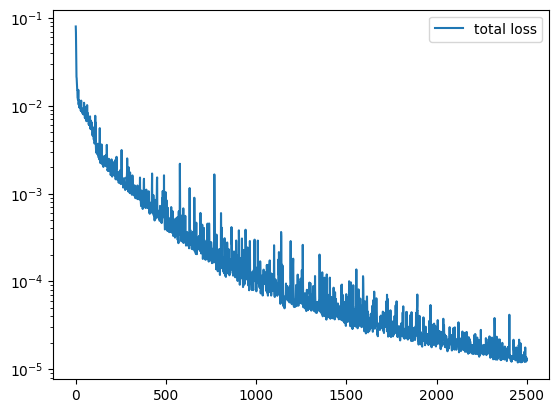

In [39]:
plt.plot(losses, label='total loss')
plt.legend()
plt.yscale('log')
plt.show()

In [40]:
# Helper function for not distorting 3D plots
def set_axes_equal_tensorflow(ax, x, y, z):
    x = tf.reshape(x, [-1]).numpy()
    y = tf.reshape(y, [-1]).numpy()
    z = tf.reshape(z, [-1]).numpy()

    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    z_min, z_max = z.min(), z.max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    z_range = z_max - z_min

    max_range = max(x_range, y_range, z_range)

    x_middle = 0.5 * (x_max + x_min)
    y_middle = 0.5 * (y_max + y_min)
    z_middle = 0.5 * (z_max + z_min)

    ax.set_xlim([x_middle - max_range/2, x_middle + max_range/2])
    ax.set_ylim([y_middle - max_range/2, y_middle + max_range/2])
    ax.set_zlim([z_middle - max_range/2, z_middle + max_range/2])


In [41]:
def modelResults(model, sensor_points, surface, umin=0.0, umax=1.0, vmin=-np.pi/2, vmax=1.0, t_steps=3, tmin=tmin, tmax=tmax, resolution=100, load=False, saveplots=False):
  if load:
    model.load_weights(load)

  X_sens = sensor_points[:, :, 0]
  Y_sens = sensor_points[:, :, 1]
  Z_sens = sensor_points[:, :, 2]

  test_pde_pts, _, _, _ = generatePoints(resolution, sphere, sensor_points, umin=umin, umax=umax, vmin=vmin, vmax=vmax, tmin=tmin, tmax=tmax)

  test_radii, test_heights = bellAndHeight(1)

  u_sens_pts = tf.tile(u0(X_sens, Y_sens, Z_sens, test_radii, test_heights), multiples=[resolution, 1])

  x, y, z = test_pde_pts[:,0:1], test_pde_pts[:,1:2], test_pde_pts[:,2:3]

  norm_pred = None

  for i in range(t_steps+1):
    t = tf.ones_like(x) * (i * tmax / t_steps)

    x, y, z, t = tf.squeeze(x), tf.squeeze(y), tf.squeeze(z), tf.squeeze(t)

    u_pred = tf.reshape(hardConstraint(model, x, y, z, t, u_sens_pts, test_radii, test_heights), x.shape).numpy()

    print(f"t={i * tmax / t_steps}")

    if i == 0:
      norm_pred = plt.Normalize(vmin=u_pred.min(), vmax=u_pred.max())

    colors_pred = plt.cm.magma(norm_pred(u_pred))

    X = x.numpy().ravel()
    Y = y.numpy().ravel()
    Z = z.numpy().ravel()

    UP = u_pred.ravel()       
      
    fig = plt.figure(figsize=(18, 6))
    ax2    = fig.add_subplot(133, projection='3d')

    ax2.set_box_aspect([1, 1, 1])

    sc_pred = ax2.scatter(
        X, Y, Z,
        c=UP,
        cmap='magma',
        norm=norm_pred,
        marker='o'
    )

    fig.colorbar(sc_pred, ax=ax2,  shrink=0.6)

    set_axes_equal_tensorflow(ax2,    x, y, z)

    ax2.view_init(elev=15, azim=250)

    plt.show()

  if saveplots:
    plt.savefig(f'{surface.__name__}_results.png')
  plt.show()

t=0.0


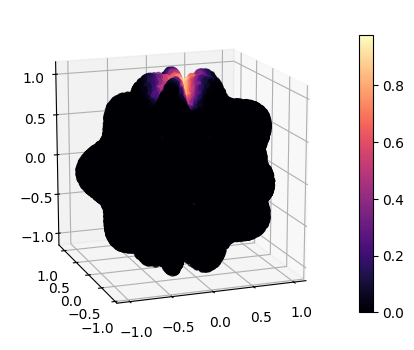

t=0.25


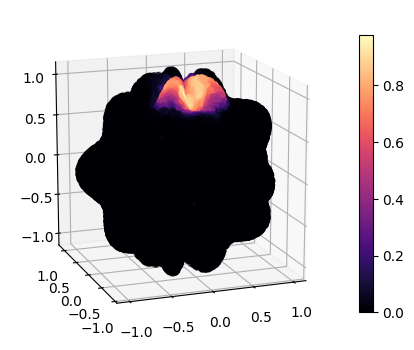

t=0.5


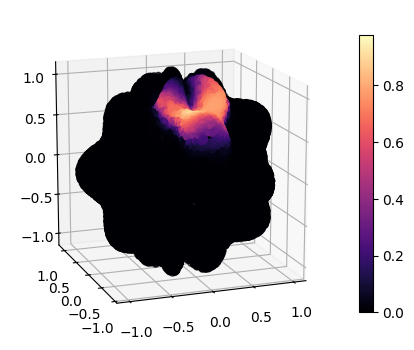

t=0.75


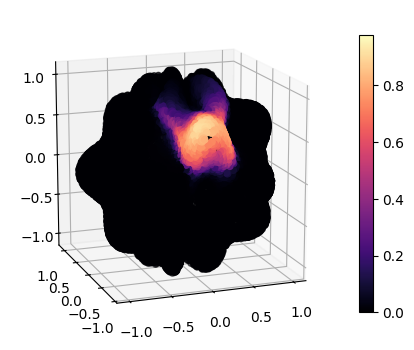

t=1.0


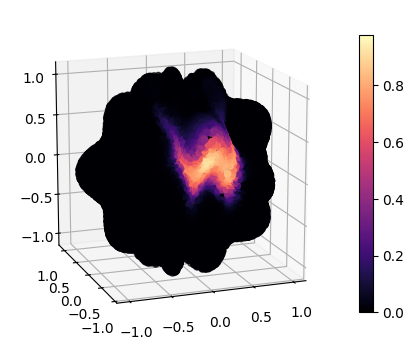

In [42]:
modelResults(model, sensor_points, sphere, umin=umin, umax=umax, vmin=vmin, vmax=vmax, t_steps=4, tmin=tmin, tmax=tmax, resolution=15000, load=False, saveplots=False)